## Loading MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

input_dim = 28 * 28
hidden_dim = 64
output_dim = 10 
batch_size = 32
learning_rate = 0.001
num_epochs = 30


# Preprocess dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset))

60000 10000


### MLP model

In [44]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
            nn.LogSoftmax(dim=1)  # Classification Head
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
mlp = MLP(input_dim, hidden_dim, output_dim, dropout_rate=0)
criterion = nn.NLLLoss()
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

## TRAINING LOOP
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        outputs = mlp(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    ## EVALUATION ON TEST SET
    mlp.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = mlp(images)
            test_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    test_losses.append(running_test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/60], Train Loss: 2.2753, Test Loss: 2.2356
Epoch [2/60], Train Loss: 2.1251, Test Loss: 1.9298
Epoch [3/60], Train Loss: 1.5891, Test Loss: 1.1794
Epoch [4/60], Train Loss: 0.9269, Test Loss: 0.7091
Epoch [5/60], Train Loss: 0.6542, Test Loss: 0.5698
Epoch [6/60], Train Loss: 0.5604, Test Loss: 0.5084
Epoch [7/60], Train Loss: 0.5070, Test Loss: 0.4666
Epoch [8/60], Train Loss: 0.4687, Test Loss: 0.4348
Epoch [9/60], Train Loss: 0.4391, Test Loss: 0.4108
Epoch [10/60], Train Loss: 0.4141, Test Loss: 0.3898
Epoch [11/60], Train Loss: 0.3937, Test Loss: 0.3718
Epoch [12/60], Train Loss: 0.3763, Test Loss: 0.3557
Epoch [13/60], Train Loss: 0.3620, Test Loss: 0.3439
Epoch [14/60], Train Loss: 0.3493, Test Loss: 0.3322
Epoch [15/60], Train Loss: 0.3376, Test Loss: 0.3207
Epoch [16/60], Train Loss: 0.3274, Test Loss: 0.3150
Epoch [17/60], Train Loss: 0.3176, Test Loss: 0.3068
Epoch [18/60], Train Loss: 0.3083, Test Loss: 0.2963
Epoch [19/60], Train Loss: 0.2994, Test Loss: 0.2892
Ep

In [ ]:
mlp_w_dropout = MLP(input_dim, hidden_dim, output_dim, dropout_rate=0.2)
criterion = nn.NLLLoss()
optimizer = optim.SGD(mlp_w_dropout.parameters(), lr=learning_rate)

do_train_losses = []
do_train_accuracies = []
do_test_losses = []
do_test_accuracies = []

for epoch in range(num_epochs):
    mlp_w_dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        outputs = mlp_w_dropout(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    do_train_losses.append(running_loss / len(train_loader))
    do_train_accuracies.append(100 * correct / total)

    mlp_w_dropout.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = mlp_w_dropout(images)
            test_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    do_test_losses.append(running_test_loss / len(test_loader))
    do_test_accuracies.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/60], Train Loss: 2.2835, Test Loss: 2.2436
Epoch [2/60], Train Loss: 2.1841, Test Loss: 2.0350
Epoch [3/60], Train Loss: 1.8878, Test Loss: 1.4938
Epoch [4/60], Train Loss: 1.3711, Test Loss: 0.9356
Epoch [5/60], Train Loss: 1.0412, Test Loss: 0.7267
Epoch [6/60], Train Loss: 0.8818, Test Loss: 0.6025
Epoch [7/60], Train Loss: 0.7725, Test Loss: 0.5225
Epoch [8/60], Train Loss: 0.6987, Test Loss: 0.4647
Epoch [9/60], Train Loss: 0.6457, Test Loss: 0.4243
Epoch [10/60], Train Loss: 0.6011, Test Loss: 0.3963
Epoch [11/60], Train Loss: 0.5678, Test Loss: 0.3738
Epoch [12/60], Train Loss: 0.5374, Test Loss: 0.3575
Epoch [13/60], Train Loss: 0.5159, Test Loss: 0.3382
Epoch [14/60], Train Loss: 0.4969, Test Loss: 0.3284
Epoch [15/60], Train Loss: 0.4759, Test Loss: 0.3150
Epoch [16/60], Train Loss: 0.4587, Test Loss: 0.3059
Epoch [17/60], Train Loss: 0.4467, Test Loss: 0.2948
Epoch [18/60], Train Loss: 0.4310, Test Loss: 0.2873
Epoch [19/60], Train Loss: 0.4198, Test Loss: 0.2774
Ep

### Bayesian Neural Network

In [47]:
from BayesianNeuralNetwork import BayesianNN
import torch.nn.functional as F

kl_weight = 1e-6

model = BayesianNN(input_size=input_dim, output_size=output_dim, num_hidden_layers=num_hidden_layers, layer_width=hidden_dim)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

bay_train_losses = []
bay_train_accuracies = []
bay_test_losses = []
bay_test_accuracies = []

tracked_mu = [model.net[0].mu[0, 0].item()]
tracked_sigma = [model.net[0].rho[0, 0].item()]


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Ajouter la perte KL
        kl_loss = model.compute_total_kl_loss()
        total_loss = loss +  kl_weight * kl_loss

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    first_layer = model.net[0]  # Première couche (BayesianLayer)
    tracked_mu.append(first_layer.mu[0, 0].item())
    tracked_sigma.append(F.softplus(first_layer.rho[0, 0]).item())

    bay_train_losses.append(running_loss / len(train_loader))
    bay_train_accuracies.append(100 * correct / total)

    ## Test
    model.eval()
    running_test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            test_loss = criterion(outputs, labels) + kl_weight * model.compute_total_kl_loss()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_test_loss += test_loss

    bay_test_losses.append(running_test_loss / len(test_loader))
    bay_test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Test Loss: {running_test_loss / len(test_loader):.4f}")

Epoch [1/60], Train Loss: 2.2539, Test Loss: 1.9136
Epoch [2/60], Train Loss: 1.6125, Test Loss: 1.3609
Epoch [3/60], Train Loss: 1.2216, Test Loss: 1.0722
Epoch [4/60], Train Loss: 1.0262, Test Loss: 0.9218
Epoch [5/60], Train Loss: 0.9208, Test Loss: 0.8523
Epoch [6/60], Train Loss: 0.8489, Test Loss: 0.7973
Epoch [7/60], Train Loss: 0.8022, Test Loss: 0.7521
Epoch [8/60], Train Loss: 0.7596, Test Loss: 0.7216
Epoch [9/60], Train Loss: 0.7293, Test Loss: 0.6878
Epoch [10/60], Train Loss: 0.7123, Test Loss: 0.6734
Epoch [11/60], Train Loss: 0.6878, Test Loss: 0.6675
Epoch [12/60], Train Loss: 0.6702, Test Loss: 0.6262
Epoch [13/60], Train Loss: 0.6541, Test Loss: 0.6285
Epoch [14/60], Train Loss: 0.6443, Test Loss: 0.6108
Epoch [15/60], Train Loss: 0.6220, Test Loss: 0.6026
Epoch [16/60], Train Loss: 0.6124, Test Loss: 0.5957
Epoch [17/60], Train Loss: 0.6046, Test Loss: 0.5871
Epoch [18/60], Train Loss: 0.5990, Test Loss: 0.5706
Epoch [19/60], Train Loss: 0.5874, Test Loss: 0.5533
Ep

## Visualizations

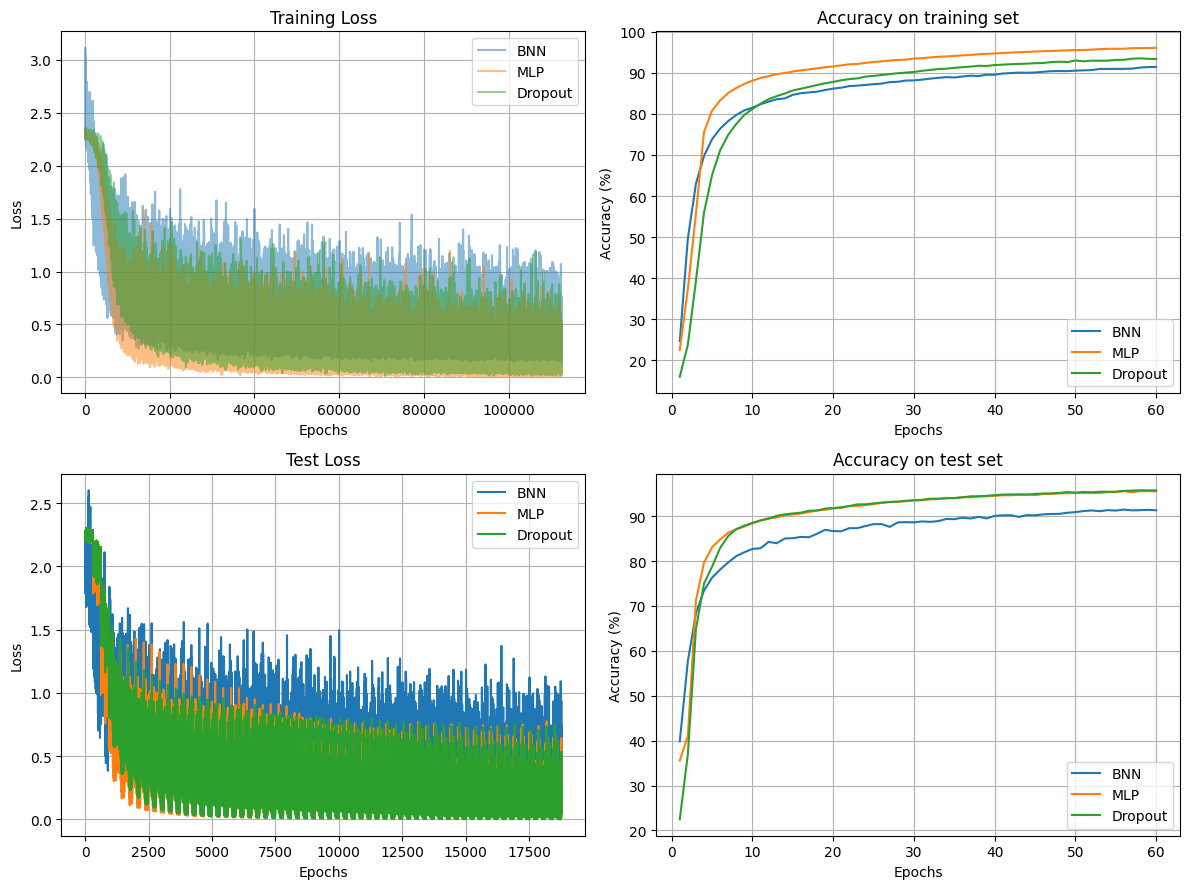

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

# Courbe de la perte
plt.subplot(2, 2, 1)
plt.plot(range(len(bay_train_losses)), bay_train_losses, label='BNN', alpha=0.5)
plt.plot(range(len(train_losses)), train_losses, label='MLP', alpha=0.5)
plt.plot(range(len(do_train_losses)), do_train_losses, label="Dropout", alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

# Courbe de l'accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), bay_train_accuracies, label='BNN')
plt.plot(range(1, num_epochs + 1), train_accuracies, label="MLP")
plt.plot(range(1, num_epochs + 1), do_train_accuracies, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on training set')
plt.legend()
plt.grid()


plt.subplot(2, 2, 3)
plt.plot(range(len(bay_test_losses)), bay_test_losses, label='BNN')
plt.plot(range(len(test_losses)), test_losses, label='MLP')
plt.plot(range(len(do_test_losses)), do_test_losses, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), bay_test_accuracies, label='BNN')
plt.plot(range(1, num_epochs + 1), test_accuracies, label="MLP")
plt.plot(range(1, num_epochs + 1), do_test_accuracies, label="Dropout")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on test set')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


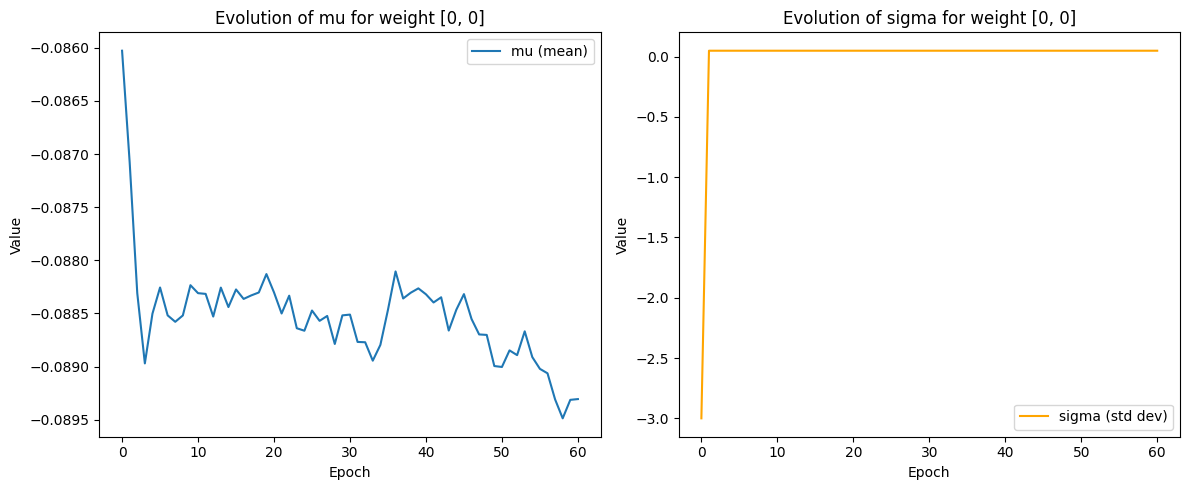

In [72]:
# Affichage des variations de mu et sigma
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tracked_mu, label="mu (mean)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Evolution of mu for weight [0, 0]")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tracked_sigma, label="sigma (std dev)", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Evolution of sigma for weight [0, 0]")
plt.legend()

plt.tight_layout()
plt.show()

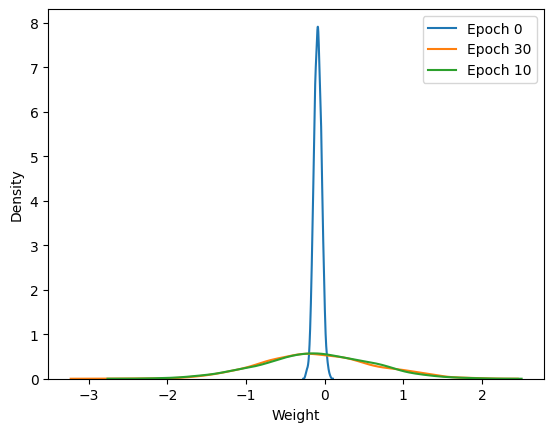

In [73]:
import numpy as np
import seaborn as sns 


for i in [0, num_epochs//2, 10]:
    eps = np.random.normal(0, 1, size=1000)
    dist = tracked_mu[i] + np.log(1 + np.exp(tracked_sigma[i])) * eps
    sns.kdeplot(dist, label=f"Epoch {i}", fill=False)

plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend()
plt.show()

## Weight Distribution

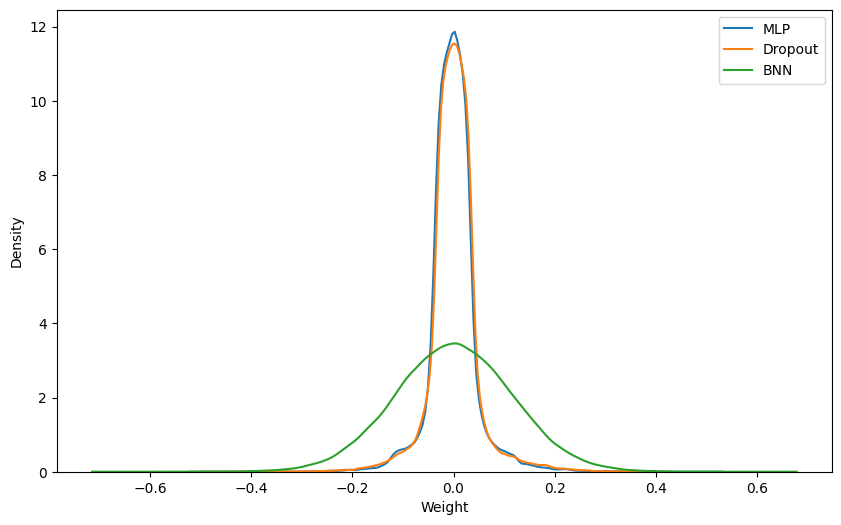

In [74]:
from BayesianNeuralNetwork import BayesianLayer


mlp_weights = np.concatenate([param.detach().cpu().numpy().flatten() for param in mlp.parameters()])
do_weights = np.concatenate([param.detach().cpu().numpy().flatten() for param in mlp_w_dropout.parameters()])


def get_weights_bayesianNN(model):
    all_w = []

    # Parcourir les couches pour récupérer les paramètres mu
    for module in model.children():
        for layer in module.children():
            if isinstance(layer, BayesianLayer):
                mu = layer.mu.detach().cpu().numpy().flatten()
                sigma = F.softplus(layer.rho).detach().cpu().numpy().flatten()
                all_w.append(mu + sigma * np.random.normal(0, 1, size=mu.size))
                

    all_w = np.concatenate(all_w)
    return all_w

bay_weights = get_weights_bayesianNN(model)



plt.figure(figsize=(10, 6))
sns.kdeplot(mlp_weights, fill=False, label="MLP")
sns.kdeplot(do_weights, fill=False, label="Dropout")
sns.kdeplot(bay_weights.flatten(), fill=False, label="BNN")

plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend()
plt.show()